# Training a Convolution Neural Network to classify Malaria cells

By Nijo Jacob, Sushanth Reddy

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip '/content/gdrive/MyDrive/cell_images.zip' -d '/content/cell_images/'

**Introduction **
* There are lot of published and popular  classification dataset such as MNIST 
that identify numbers based on images and CIFAR-10 identification of animals images.
* We focus on anaylze dataset that can be useful in medical field especially valuable in research laboratory  in identify malaria cells seen at microscopic level.
* We can identify images that were  taken from microscopic and then run through CNN to predict what is parasite and uninfected.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action="ignore")
from matplotlib.image import imread
#from IPython.display import SVG
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import keras
#tensorflow modules

from keras import backend as K

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.utils.np_utils import to_categorical  
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import InputLayer
from keras.optimizers import RMSprop
from keras.layers import BatchNormalization



from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

import random, cv2

**Contribution **
* Dataset was imported from kaggle
* There were total of 27,558 images containing both parasite and uninfected.



In [ ]:
directorylabel = "/content/cell_images/" 
uninfected,parasitized= os.listdir(directorylabel)
print("Uninfected: ",len(os.listdir(directorylabel + uninfected)))
print("Parasitized: ", len(os.listdir(directorylabel + parasitized)))


Uninfected:  13780
Parasitized:  13780


Images had variant sizes

In [ ]:
img_dir = directorylabel + parasitized 
imgfile = np.random.choice(os.listdir(img_dir))
shape= img_dir + "/" + imgfile
print("Shape of image: ",imread(shape).shape)

Shape of image:  (121, 136, 3)


In [ ]:
def plotdata(data,type):
  plt.figure(figsize=(10,10))
  for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    imgdir = data + type
    imgfile = np.random.choice(os.listdir(imgdir))
    img = cv2.imread(imgdir+"/"+imgfile)
    plt.imshow(img)
    plt.title(type)
  plt.show()


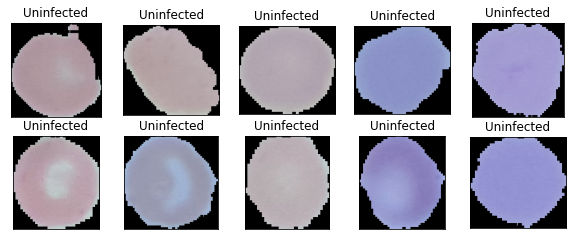

In [ ]:
plotdata(directorylabel,uninfected)

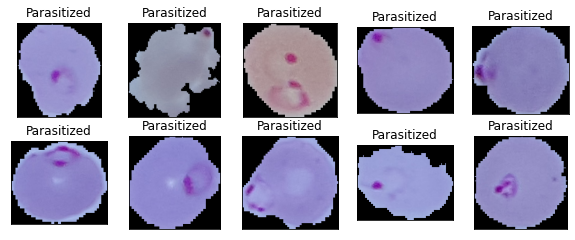

In [ ]:
plotdata(directorylabel,parasitized)

In [ ]:
combined_data = []
for i in os.listdir(directorylabel):
    sub_directory = os.path.join(directorylabel,i)
    for j in os.listdir(sub_directory):
      ext = os.path.splitext(j)[-1].lower()
      if ext == ".png":
        img = cv2.imread(os.path.join(sub_directory,j),3)
        img = cv2.resize(img,(32,32))
        combined_data.append([img,i])

Randomizing list

In [ ]:
random.shuffle(combined_data)

In [ ]:
len(combined_data)

27558

Split into Validation and Training

In [ ]:
num_train = int(round(len(combined_data)*0.8))
train_data, test_data = combined_data[:num_train], combined_data[num_train:]

Extract Features and Label for both training and testing list. Changes to float 32 types and Normalization images data to 0 and 1. Convert Label string into Binary

In [ ]:
def image_label(data):
  image = []
  labels = []
  for features,label in data:
    image.append(features)
    labels.append(label)
  image = np.array(image)
  image = image.astype('float32') / 255.0
  labels = LabelBinarizer().fit_transform(labels)
  labels = np.hstack((labels, 1 - labels))
  labels = np.array(labels)
  return image,labels

In [ ]:
image_train,label_train = image_label(train_data)

In [ ]:
image_test,label_test = image_label(test_data)

This is Cross Entropy Function 

In [ ]:
def loss(x, y):
        x = tf.cast(x,tf.float32)
        y = tf.cast(y,tf.float32)
        loss = x * K.log(y)
        loss = -K.sum(loss, -1)
        return loss

**CNN Model**


*   Contains three layers of Convolution Layer 
*   Three  Batch Normalization layer
*   Three Max Pooiling 
*   Including hidden layers: Flatten, Dropout and Dense





In [ ]:
def CNNModel(input_value,loss,training_algorithm,image_train,label_train,validation,epoch):
  model = Sequential()
  model.add(InputLayer(input_shape=input_value))

  model.add(Conv2D(32,(3,3), activation='relu',padding="same"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Conv2D(64,(3,3),activation='relu',padding="same"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Conv2D(128,(3,3),activation='relu',padding="same"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())


  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2,activation='softmax'))

#compiling the model
  model.compile(loss=loss,optimizer=training_algorithm ,metrics=["accuracy"])

#summary of the model
  model.summary()
  early_stop = EarlyStopping(monitor="val_loss",patience=5, verbose=True)
  return model.fit(image_train,label_train,validation_data=validation,epochs=epoch,callbacks=[early_stop], verbose=1)

In [ ]:
history = CNNModel((32, 32, 3),loss,'adam',image_train, label_train,(image_test,label_test),20)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)        

In [ ]:
CNNModel((64, 64, 3),'categorical_crossentropy','adam',image_train, label_train,(image_test,label_test),20)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

In [ ]:
CNNModel((128, 128, 3),'categorical_crossentropy','adam',image_train, label_train,(image_test,label_test),20)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
module_wrapper_16 (ModuleWra (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 128)      

Here is the Graph of Training and Validation Accuracy using Our Cross Entropy Loss Function

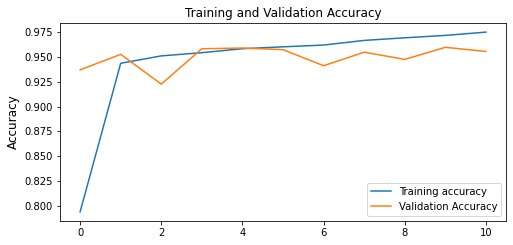

In [ ]:
acc = history.history["accuracy"]
loss = history.history["loss"]

val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc,label="Training accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.show()

Here is the Graph of Training and Validation Loss using Our Cross Entropy Loss Function

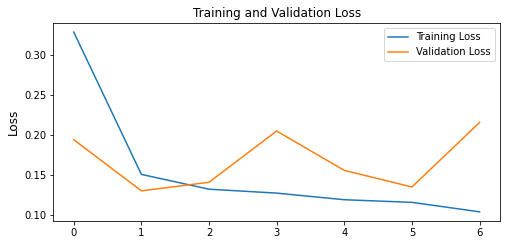

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss",fontsize=12)
plt.show()

In [ ]:
sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, decay=0.0, nesterov=False)
CNNModel((32, 32, 3),'categorical_crossentropy',sgd, image_train, label_train,(image_test,label_test),20)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
module_wrapper_36 (ModuleWra (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
module_wrapper_37 (ModuleWra (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 8, 8, 128)       

In [ ]:
rms_prop = RMSprop(lr=0.0001,momentum=0.0, rho=0.9, epsilon=1e-7)
CNNModel((32, 32, 3),'categorical_crossentropy',rms_prop, image_train, label_train,(image_test,label_test),20)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)        

Transfer Learning using VGG16

In [ ]:
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))
display(vgg_model.summary())
# Set to false the layers except the last set of conv laer and their pooling
for layer in vgg_model.layers[:15]:
    layer.trainable = False
# Check the trainable status of the individual layers
for layer in vgg_model.layers[-5:]:
    print(layer, layer.trainable)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

None

<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f541a1f8950> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f541a188c90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f541a25a710> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f541a1aaf90> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f541a1dfb50> True


In [ ]:
existing_model = Sequential()
existing_model.add(vgg_model)
existing_model.add(Flatten())
existing_model.add(Dense(1024, activation='relu'))
existing_model.add(Dropout(0.5))
existing_model.add(BatchNormalization())
existing_model.add(Dense(2, activation='softmax'))
existing_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
early_stop = EarlyStopping(monitor="val_loss",patience=5, verbose=True)
history = existing_model.fit(image_train, label_train,epochs=20,batch_size =50,callbacks=[early_stop], validation_data=(image_test,label_test), verbose=True)

Epoch 1/20
441/441 [==============================] - 11s 22ms/step - loss: 0.3140 - accuracy: 0.8646 - val_loss: 0.2222 - val_accuracy: 0.9071
Epoch 2/20
441/441 [==============================] - 9s 20ms/step - loss: 0.2449 - accuracy: 0.8990 - val_loss: 0.2077 - val_accuracy: 0.9165
Epoch 3/20
441/441 [==============================] - 9s 20ms/step - loss: 0.2270 - accuracy: 0.9073 - val_loss: 0.2350 - val_accuracy: 0.8979
Epoch 4/20
441/441 [==============================] - 9s 20ms/step - loss: 0.2080 - accuracy: 0.9153 - val_loss: 0.4982 - val_accuracy: 0.8354
Epoch 5/20
441/441 [==============================] - 9s 20ms/step - loss: 0.2008 - accuracy: 0.9194 - val_loss: 0.2042 - val_accuracy: 0.9209
Epoch 6/20
441/441 [==============================] - 9s 20ms/step - loss: 0.1949 - accuracy: 0.9215 - val_loss: 0.1882 - val_accuracy: 0.9253
Epoch 7/20
441/441 [==============================] - 9s 21ms/step - loss: 0.1853 - accuracy: 0.9254 - val_loss: 0.2720 - val_accuracy: 0.900

**Future Work**


*   Try another pretrained model: ResNet 18 and ResNet 50
*   Image Augmentation- large dataset
*   K-mean Clustering 



